In [1]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# PyTorch and ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Main imports
import heyoka as hy
import pykep as pk
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
if torch.cuda.is_available():
    print("PyTorch detected CUDA")
    device = torch.device("cuda:7")
else: 
    print("PyTorch DIN NOT detect CUDA")
    device = torch.device("cpu")
print("Training on :", device)

PyTorch detected CUDA
Training on : cuda:7


# Model definition

In [3]:
# A FFNN with continuous activation functions (softplus)
neurons = 128
model = nn.Sequential(
          nn.Linear(6,neurons),
          nn.Softplus(),
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,3),
        )
model = model.cuda(device)

In [4]:
#model.load_state_dict(torch.load("data/training_50000_100_[0.001, 0.001, 0.08, 0.08]_[1.0, 1.0, 1.0, 1.0].pk_300_epochs_4_layers_128_neurons_4096_batch_size_loss2.mdl"))
#150_epochs_4_layers_128_neurons_0.0_fault_1_slices_8192_batch_size_digital_loss2_analog.mdl
#model.load_state_dict(torch.load("models/150_epochs_4_layers_128_neurons_0.0_fault_1_slices_8192_batch_size_digital_loss2_analog.mdl"))
model.load_state_dict(torch.load("models/150_epochs_4_layers_128_neurons_0.0_fault_1_slices_8192_batch_size_digital_loss2_analog.mdl"))


<All keys matched successfully>

# Load trajectories
Ideally these will be not the ones we used for training (good practive) even if in this particular case and application there is not much difference

In [5]:
with open("data/test_4_189_250_100_[0.001, 0.001, 0.001, 0.001]_[1.0, 1.0, 1.0, 1.0].pk", "rb") as file:
    data = pkl.load(file)

In [6]:
traj_id = 34
# We load the data for one particular trajectory
state = torch.tensor(data[traj_id][:,:6], device=device)
labels = torch.tensor(data[traj_id][:,6:9], device=device)

In [7]:
# We compute the thrust predicted by the model
predictions = model(state.float())
norms = torch.norm(predictions, dim=1)
predictions = predictions/norms.view(-1,1)

In [8]:
def cart2angles(cart):
    theta = torch.acos(cart[:,2])
    phi = torch.atan2(cart[:,1], cart[:,0])
    return theta, phi

In [9]:
theta, phi = cart2angles(predictions)
theta_labels, phi_labels = cart2angles(labels)
tf = 4.6194
tgrid = np.linspace(0, tf, 100)

Text(0, 0.5, 'x')

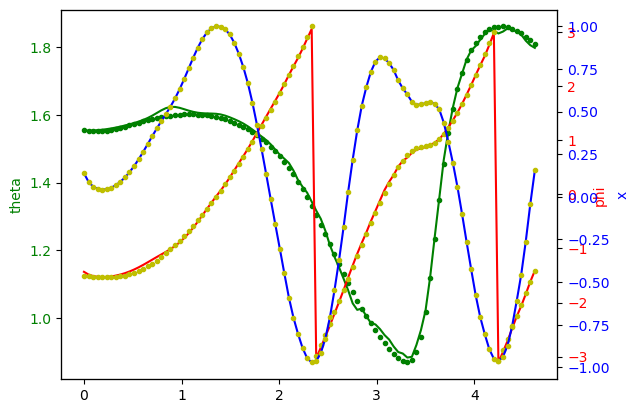

In [10]:
fig, ax1 = plt.subplots()

color = 'g'
ax1.plot(tgrid, theta.detach().cpu(), color)
ax1.plot(tgrid, theta_labels.detach().cpu(), 'g.', label = "theta")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('theta', color=color)

color = 'r'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tgrid, phi.detach().cpu(), color)
ax2.plot(tgrid, phi_labels.detach().cpu(), 'y.', label = "phi")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('phi', color=color)


color = 'b'
ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot(tgrid, predictions[:,0].detach().cpu(), color)
ax3.plot(tgrid, predictions[:,0].detach().cpu(), 'y.', label = "phi")
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylabel('x', color=color)



Text(0.5, 1.0, 'Example Trajectory id:(34)')

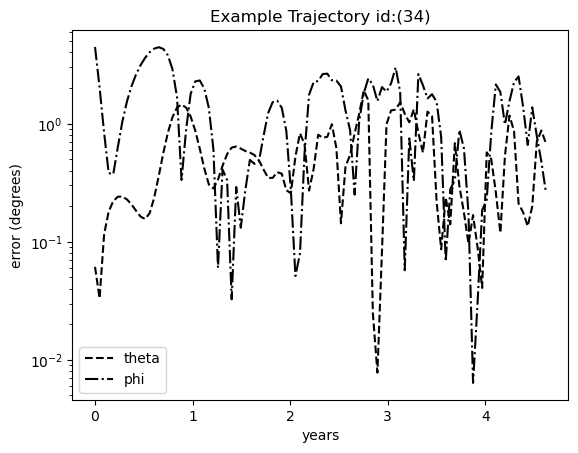

In [11]:
plt.figure()
plt.semilogy(tgrid, np.abs(theta.detach().cpu() - theta_labels.detach().cpu()) / np.pi*180, "k--", label="theta")
plt.semilogy(tgrid, np.abs(phi.detach().cpu() - phi_labels.detach().cpu()) / np.pi*180, "k-.", label="phi")
plt.legend()
plt.xlabel("years")
plt.ylabel("error (degrees)")
plt.title(f"Example Trajectory id:({traj_id})")

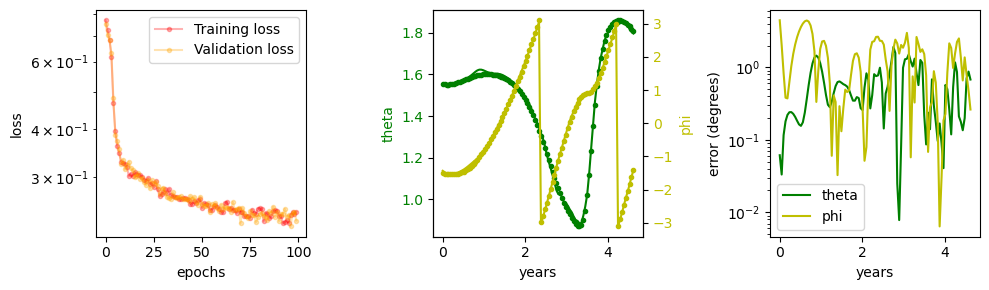

In [12]:
with open("figures/loss_data.pk", "rb") as file:
    loss_list, loss_val_list = pkl.load(file)

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].semilogy(loss_list, 'red', marker='.',label='Training loss', alpha=0.3)
axes[0].semilogy(loss_val_list, 'orange', marker='.', label='Validation loss', alpha=0.3)
axes[0].legend()
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epochs')


color = 'g'
axes[1].plot(tgrid, theta.detach().cpu(), color)
axes[1].plot(tgrid, theta_labels.detach().cpu(), 'g.', label = "theta")
axes[1].tick_params(axis='y', labelcolor=color)
axes[1].set_ylabel('theta', color=color)
axes[1].set_xlabel('years')


color = 'y'
ax2 = axes[1].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tgrid, phi.detach().cpu(), color)
ax2.plot(tgrid, phi_labels.detach().cpu(), 'y.', label = "phi")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('phi', color=color)

axes[2].semilogy(tgrid, np.abs(theta.detach().cpu() - theta_labels.detach().cpu()) / np.pi*180, "g", label="theta")
axes[2].semilogy(tgrid, np.abs(phi.detach().cpu() - phi_labels.detach().cpu()) / np.pi*180, "y", label="phi")
axes[2].legend()
axes[2].set_xlabel("years")
axes[2].set_ylabel("error (degrees)")


plt.tight_layout()

In [13]:
plt.savefig("figures/loss.png", dpi=600)

<Figure size 640x480 with 0 Axes>